In [47]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import ast


In [48]:

# [Step 1: Data Preprocessing]
# Load data
data = pd.read_csv('calculated_data.csv')

# Function to convert string to list


def convert_string_to_list(item, desired_length=2):
    # Check if the item is already a number (int or float)
    if isinstance(item, (int, float)):
        return [item] * desired_length

    # Ensure the input is treated as a string
    string = str(item)

    # Replace 'nan' with '0' in the string
    string = string.replace('nan', '0')

    # Convert the string to a list
    try:
        lst = ast.literal_eval(string)
    except:
        lst = [0] * desired_length

    # Pad or truncate the list to ensure it's of the desired length
    if len(lst) < desired_length:
        lst.extend([0] * (desired_length - len(lst)))
    elif len(lst) > desired_length:
        lst = lst[:desired_length]

    return lst


# Apply the conversion function to 'NDVI' and 'NBR' columns
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))

# Define your thresholds
nbr_burnt_threshold = 0.3  # Example threshold, adjust based on your data
ndvi_burnt_threshold = 0.3  # Example threshold, adjust based on your data


# Function to classify based on average NBR and NDVI
def classify_area(ndvi_list, nbr_list):
    # Calculate the average of the lists
    avg_ndvi = sum(ndvi_list) / len(ndvi_list) if ndvi_list else 0
    avg_nbr = sum(nbr_list) / len(nbr_list) if nbr_list else 0

    # Classification logic
    if avg_nbr > nbr_burnt_threshold:
        if avg_ndvi < ndvi_burnt_threshold:
            return 'Burnt'
        else:
            return 'Potentially Burnt'
    else:
        return 'Unburnt'


# Apply classification to each row in DataFrame
data['Status'] = data.apply(
    lambda row: classify_area(row['NDVI'], row['NBR']), axis=1)


# Flatten the NDVI and NBR columns
X = np.array([np.ravel([ndvi, nbr])
             for ndvi, nbr in zip(data['NDVI'], data['NBR'])])

# Print the number of rows in the data and the size of the flattened data array
print("Number of rows in the data:", len(data))
print("Size of the flattened data array:", X.shape)


Number of rows in the data: 919
Size of the flattened data array: (919, 4)


In [49]:

# [Step 2: DBSCAN Clustering]
# Initialize and fit DBSCAN


# Check for NaN values in X
if np.isnan(X).any():
    print("NaN values detected in X. Imputing with 0.")
    X = np.nan_to_num(X)

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)

# Fit the model
dbscan.fit(X)

# Get cluster labels
labels = dbscan.labels_

# Print the unique labels
print("Unique cluster labels:", np.unique(labels))


NaN values detected in X. Imputing with 0.
Unique cluster labels: [-1  0]


In [50]:

# Step 3: Cluster Analysis and Classification

# Initialize an empty DataFrame for cluster means
cluster_means = pd.DataFrame(columns=['Cluster', 'Mean_NDVI', 'Mean_NBR'])

# Calculate mean NDVI and NBR for each cluster
for label in np.unique(labels):
    if label != -1:  # Exclude noise points
        cluster_data = X[labels == label]
        mean_ndvi = np.mean([item[0] for item in cluster_data])
        mean_nbr = np.mean([item[1] for item in cluster_data])
        new_row = pd.DataFrame({'Cluster': [label], 'Mean_NDVI': [
                               mean_ndvi], 'Mean_NBR': [mean_nbr]})
        cluster_means = pd.concat([cluster_means, new_row], ignore_index=True)

# Determine burnt and unburnt clusters
# Adjust these thresholds based on your specific data and domain knowledge
burnt_threshold = {'NDVI': 0.1, 'NBR': 0.1}
cluster_means['Status'] = cluster_means.apply(lambda row: 'Burnt' if row['Mean_NDVI'] <
                                              burnt_threshold['NDVI'] and row['Mean_NBR'] < burnt_threshold['NBR'] else 'Unburnt', axis=1)

# Map cluster labels to original data
data['Status'] = [cluster_means.loc[cluster_means['Cluster'] == label,
                                    'Status'].values[0] if label != -1 else 'Unknown' for label in labels]

# Display the first few rows of the data with their status
print(data.head())


                                                             ID  \
20230813_100  [0.7755693773142729, 0.8109320515721594, 0.851...   
20230813_101  [0.34495916148451133, 0.24291931815932866, 0.2...   
20230813_102  [0.8418304439153839, 0.798698150698662, 0.8062...   
20230813_103  [0.5716647915500211, 0.5872206605870187, 0.589...   
20230813_104  [-0.2217794764351386, -0.22595804483580587, -0...   

                                                      NDVI         NBR Status  
20230813_100  [0.003078832689977299, 0.049812837737360276]  [nan, nan]  Burnt  
20230813_101  [0.05116118296949416, -0.026290510714717576]  [nan, nan]  Burnt  
20230813_102   [0.058663947405941635, 0.04357172884127514]  [nan, nan]  Burnt  
20230813_103  [0.019482128930850738, 0.009917857640267346]  [nan, nan]  Burnt  
20230813_104   [0.006908720294918405, 0.00880010401111331]  [nan, nan]  Burnt  


/var/folders/qp/39q3q5193vb9k27hwzyk9fk80000gn/T/ipykernel_83791/2310456882.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_means = pd.concat([cluster_means, new_row], ignore_index=True)


/var/folders/qp/39q3q5193vb9k27hwzyk9fk80000gn/T/ipykernel_83791/2353775590.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis')


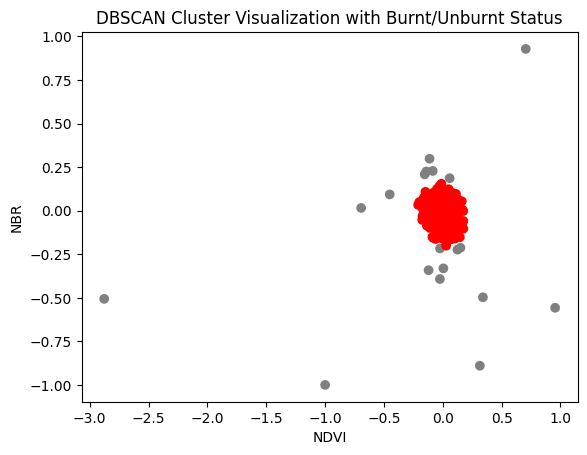

In [51]:
# Add cluster labels and status to your DataFrame
data['Cluster'] = labels

# Map 'Status' to a color
color_map = {'Burnt': 'red', 'Unburnt': 'green', 'Unknown': 'gray'}
colors = data['Status'].map(color_map)

# Visualize the clusters with color coding
plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis')
plt.xlabel('NDVI')
plt.ylabel('NBR')
plt.title('DBSCAN Cluster Visualization with Burnt/Unburnt Status')
plt.show()


NaN values detected in X. Imputing with 0.


/var/folders/qp/39q3q5193vb9k27hwzyk9fk80000gn/T/ipykernel_83791/3391481968.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_means = pd.concat([cluster_means, new_row], ignore_index=True)
/var/folders/qp/39q3q5193vb9k27hwzyk9fk80000gn/T/ipykernel_83791/3391481968.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis')


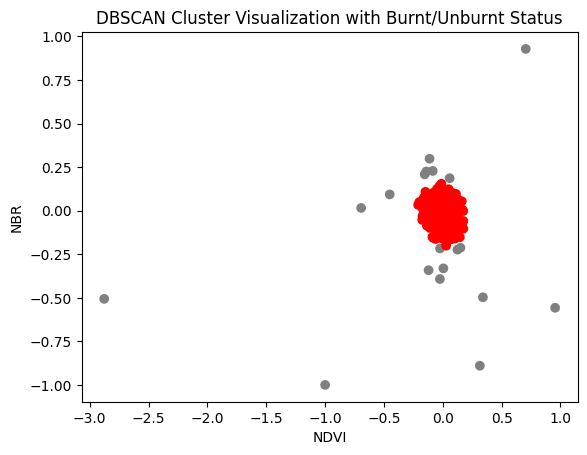

In [52]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import ast

# [Step 1: Data Preprocessing]
# Load data
data = pd.read_csv('calculated_data.csv')

# Function to convert string to list


def convert_string_to_list(item, desired_length=2):
    if isinstance(item, (int, float)):
        return [item] * desired_length
    string = str(item)
    string = string.replace('nan', '0')
    try:
        lst = ast.literal_eval(string)
    except:
        lst = [0] * desired_length
    if len(lst) < desired_length:
        lst.extend([0] * (desired_length - len(lst)))
    elif len(lst) > desired_length:
        lst = lst[:desired_length]
    return lst


# Apply the conversion function to 'NDVI' and 'NBR' columns
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))

# Flatten the NDVI and NBR columns
X = np.array([np.ravel([ndvi, nbr])
             for ndvi, nbr in zip(data['NDVI'], data['NBR'])])

# [Step 2: DBSCAN Clustering]
# Check for NaN values in X
if np.isnan(X).any():
    print("NaN values detected in X. Imputing with 0.")
    X = np.nan_to_num(X)

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_

# [Step 3: Cluster Analysis and Classification]
# Initialize an empty DataFrame for cluster means
cluster_means = pd.DataFrame(columns=['Cluster', 'Mean_NDVI', 'Mean_NBR'])

# Calculate mean NDVI and NBR for each cluster
for label in np.unique(labels):
    if label != -1:  # Exclude noise points
        cluster_data = X[labels == label]
        mean_ndvi = np.mean([item[0] for item in cluster_data])
        mean_nbr = np.mean([item[1] for item in cluster_data])
        new_row = pd.DataFrame({'Cluster': [label], 'Mean_NDVI': [
                               mean_ndvi], 'Mean_NBR': [mean_nbr]})
        cluster_means = pd.concat([cluster_means, new_row], ignore_index=True)

# Define thresholds
burnt_threshold = {'NDVI': 0.1, 'NBR': 0.1}
cluster_means['Status'] = cluster_means.apply(lambda row: 'Burnt' if row['Mean_NDVI'] <
                                              burnt_threshold['NDVI'] and row['Mean_NBR'] < burnt_threshold['NBR'] else 'Unburnt', axis=1)

# Map cluster labels to original data
data['Cluster'] = labels
data['Status'] = data['Cluster'].map(cluster_means.set_index('Cluster')[
                                     'Status']).fillna('Unknown')

# [Visualization]
# Map 'Status' to a color
color_map = {'Burnt': 'red', 'Unburnt': 'green', 'Unknown': 'gray'}
colors = data['Status'].map(color_map)

# Visualize the clusters with color coding
plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis')
plt.xlabel('NDVI')
plt.ylabel('NBR')
plt.title('DBSCAN Cluster Visualization with Burnt/Unburnt Status')
plt.show()
